In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
import os, sys
from PIL import Image
from tqdm import tqdm
import time

In [2]:
def get_energy(image, scale=3000):
    # extract energy bar from image
    ebar_bounds = ((5,8),(145,17))
    ebar = image[ebar_bounds[0][0]:ebar_bounds[1][0], ebar_bounds[0][1]:ebar_bounds[1][1], :]

    ebar_slice = np.array([np.mean(ebar[i,1,:]) for i in range(ebar.shape[0])]) # 1d slice of energy bar
    for i in range(ebar_slice.shape[0]):
        if ebar_slice[i] != 255:
            break
    proportion_filled = 1 - (i-1)/ebar_slice.shape[0] # proportion of energy bar filled (0-1)
    event_energy = (proportion_filled * scale) # scale to max energy
    return event_energy

In [3]:
def get_track(image):
    # extract padplane from image
    padplane_bounds = ((3,40),(148,185))
    padplane = image[padplane_bounds[0][0]:padplane_bounds[1][0], padplane_bounds[0][1]:padplane_bounds[1][1], :]
    
    # extract track from padplane
    track = padplane[:,:,0].copy() # copy red channel for track
    track[track == 255] = 0 # set white to black
    track_bounds = np.where(track != 0) # get track bounds
    track_bounds = ((min(track_bounds[0]), max(track_bounds[0])+1), (min(track_bounds[1]), max(track_bounds[1])+1))
    track = track[track_bounds[0][0]:track_bounds[0][1], track_bounds[1][0]:track_bounds[1][1]] # crop track
    track = track[::4,::4] # downsample track to remove grid effect
    return track

In [4]:
def get_trace(image):
    trace_img = image[150:,:,0] # extract trace from image
    trace_cumsum = np.cumsum(255-trace_img, axis=0) # cumulative sum of trace
    trace = trace_cumsum[-1,:].astype(float) # height of trace at each pixel
    
    trace_diff = np.abs(np.diff(trace))
    edges = np.arange(trace_diff.shape[0])[trace_diff > 100] # find edges of trace
    
    # crop trace_height to edges
    trace = trace[edges[0]+5:edges[-1]-5]
    
    # set baseline to average of first and last 10 pixels
    baseline = np.mean(np.concatenate((trace[:10], trace[-10:])))
    trace -= baseline # subtract baseline
    trace[trace < 0] = 0 # set negative values to 0
    
    return trace

In [5]:
def get_trace_width(trace):
    tsum1 = np.cumsum(trace)
    tsum2 = np.cumsum(trace[::-1])[::-1]
    # find edges of trace peak
    cutoff=np.mean(trace) 
    ledge=np.arange(tsum1.shape[0])[tsum1 >= cutoff][0]
    redge=np.arange(tsum2.shape[0])[tsum2 >= cutoff][-1]
    return redge - ledge

In [6]:
def get_track_dimensions(track):
    length = (track.shape[0]**2 + track.shape[1]**2)**0.5 # length of track
    num_pads = track[track>0].reshape(-1).shape[0] # pads in track
    width = num_pads / length # width of track
    return length, width, num_pads

In [7]:
def get_event_length(length, trace_width):
    # weight of trace in length calculation
    # obtained by minimizing the standard deviation of the length calculation for events of the same energy
    trace_weight = 0.59176
    
    scale = 1/2.2 # scale factor for length calculation (pads to mm)
    overshoot = 0 # overshoot of length calculation (mm)
    
    return scale*(length**2 + trace_weight*trace_width**2)**0.5 - overshoot

In [8]:
image_dir = "/mnt/analysis/e17023/Adam/GADGET2/simOutput/images/"
i = 0

data_df = pd.DataFrame(columns=['sim','event','energy','length','width','padnum'])

for i, img in tqdm(enumerate([f for f in os.listdir(image_dir) if f.endswith('.png')])):
    img_array = np.array(Image.open(image_dir + img))[:,:,:3]
    
    # extract data from image
    event_energy = get_energy(img_array)
    track = get_track(img_array)
    trace = get_trace(img_array)
    
    # normalize energy
    track = event_energy * track / np.sum(track) # assumes all energy is represented in track pixels, bad with high threshold
    trace = event_energy * trace / np.sum(trace)
    
    trace_width = get_trace_width(trace)
    track_length, track_width, num_pads = get_track_dimensions(track)
    
    event_length = get_event_length(track_length, trace_width)
    
    sim_name = img.split('_')[0]
    event = img.split('_')[1].split('.')[0]
    data_df.loc[i] = [sim_name, event, event_energy, event_length, track_width, num_pads]
    
    if i > 1000:
        break    

1001it [00:07, 128.79it/s]


VarSim199_73.png | 1842.857142857143 keV


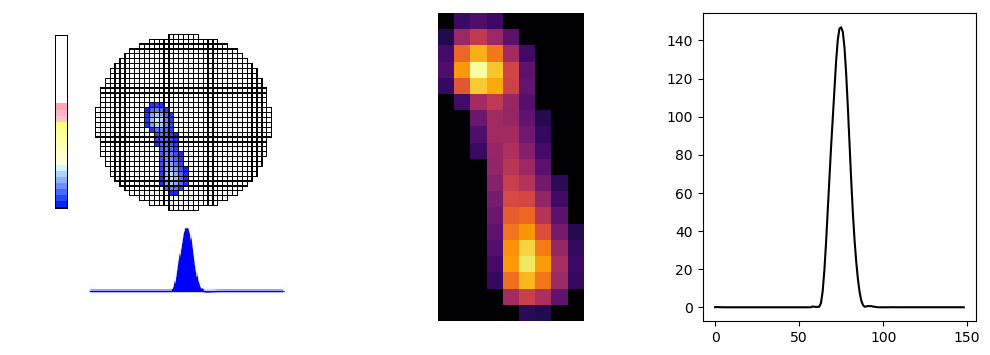

In [9]:
# display img_array, track, and trace
print(f"{img} | {event_energy} keV")
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(img_array)
ax[1].imshow(track, cmap='inferno')
ax[2].plot(trace, color='black')

# hide axes for 0 and 1
ax[0].axis('off')
ax[1].axis('off')

plt.show()